<a href="https://colab.research.google.com/github/tupoylogin/EMHAssignment/blob/main/EMHTestingAssignmentAndrosov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
URL = 'http://www.ux.ua/ru/index/stat/dailyhistoryexport.aspx?type=4&code=UX&day1=20150108&day2=20210221'
stocks = requests.get(URL).content.decode('utf-8')
stocks = pd.read_csv(io.StringIO(stocks)).fillna(0)

In [ ]:
stocks.head(10)

,<TICKER>,<PER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,UX,D,20210219,0,1864.29,1864.29,1862.41,1862.41,0.0
1,UX,D,20210218,0,1821.93,1869.51,1816.96,1864.29,137570.0
2,UX,D,20210217,0,1821.93,1821.93,1821.93,1821.93,4500.0
3,UX,D,20210216,0,1769.55,1821.93,1769.55,1821.93,255000.0
4,UX,D,20210215,0,1789.63,1789.63,1769.55,1769.55,4300.0
5,UX,D,20210212,0,1782.11,1789.63,1782.11,1789.63,157600.0
6,UX,D,20210211,0,1788.39,1788.39,1782.11,1782.11,38200.0
7,UX,D,20210210,0,1773.49,1788.39,1773.49,1788.39,55200.0
8,UX,D,20210209,0,1765.97,1788.39,1765.97,1773.49,62176.0
9,UX,D,20210208,0,1765.97,1765.97,1765.97,1765.97,0.0


In [ ]:
stocks['<RETURN>'] = (stocks['<CLOSE>'] - stocks ['<OPEN>'])/stocks['<OPEN>']
avg_return = stocks['<RETURN>'].mean()
std_return = stocks['<RETURN>'].std()

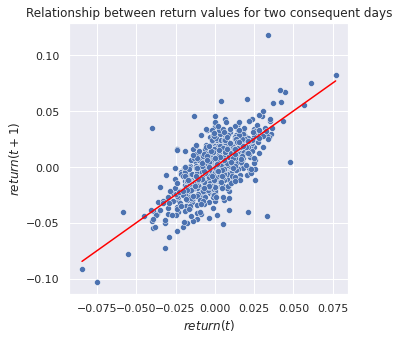

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=stocks['<RETURN>'], y=stocks['<RETURN>'].diff(1))
sns.lineplot(x=stocks['<RETURN>'], y=stocks['<RETURN>'], color='red')
ax.set_xlabel('$return(t)$')
ax.set_ylabel('$return(t+1)$')
ax.set_title('Relationship between return values for two consequent days')
plt.show()

##the Wald–Wolfowitz test
$Z = \frac{R-\mu}{\sigma} $

where

$\mu = \frac{2N_+N_-}{N} + 1, \sigma^2 = \frac{(\mu - 1)(\mu - 2)}{N - 1}$


In [ ]:
runs = np.sign(stocks['<RETURN>'] - avg_return)
r = np.abs(runs.diff(1).fillna(0)/2).sum()
# diff operator returns '2' when sign changes from '+' to '-' otherwise '-2'
# it is necessary to take absolute values and divide the sequence by 2
# then we'll have '1' for sign change and '0' otherwise
n_plus = (runs>0).sum()
n_minus = (runs<0).sum()
n = n_plus + n_minus

In [ ]:
mu = 2*n_plus*n_minus/n + 1
sigma = np.sqrt(((mu - 1)*(mu - 2))/(n - 1))
z = (r-mu)/sigma
p_val = norm.sf(np.abs(z))*2 #two-sided hypothesis check
print(f'Z = {z}\np = {p_val}')

Z = -4.217568536358359
p = 2.4695077285127747e-05


### As we can see, $p < 0.05$, thus we can reject $H_0 : \{ret(t_i) \sim i.i.d. N(0, \sigma_{t_i}), \forall i \}$

## RS Analysis

In [ ]:
def divide_chunks(l: pd.Series, n: int): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l.iloc[i:i + n]

In [ ]:
#define log-ratio
#i've decided to use close price rather than return because of log domain
log_rat = (stocks['<CLOSE>']/(stocks['<CLOSE>'].shift(1)+0.001))\
           .map(np.log).iloc[1:]
y = list()
x = list()
z = list()
for i in range(2, len(log_rat)//2+1):
  n_periods = i
  #calculate mean of each subgroup
  periods = list(divide_chunks(log_rat, n_periods))
  means = list(map(lambda x: x.mean(), periods))
  stds = list(map(lambda x: np.nan_to_num(x.std(), 0.), periods))
  diffs = list(map(lambda x: (x[0]-x[1]).cumsum(), zip(periods, means)))
  r = list(map(lambda x: x.max() - x.min(), diffs))
  rs = sum([r_i/(s_i+1e6) for r_i, s_i in zip(r, stds)])/n_periods
  ers = ((n_periods-0.5)/n_periods)*\
          np.power(np.pi*n_periods*0.5, -0.5)*\
          sum(np.sqrt([(n-i)/n for i in range(1, n+1)]))
  y.append(np.log(rs))
  z.append(ers)
  x.append(np.log(n_periods))


In [ ]:
from scipy.linalg import lstsq

In [ ]:
solution = lstsq(np.vstack((x, np.ones(len(x)))).T, y)[0]
solution_ideal = lstsq(np.vstack((x, np.ones(len(x)))).T, z)[0]

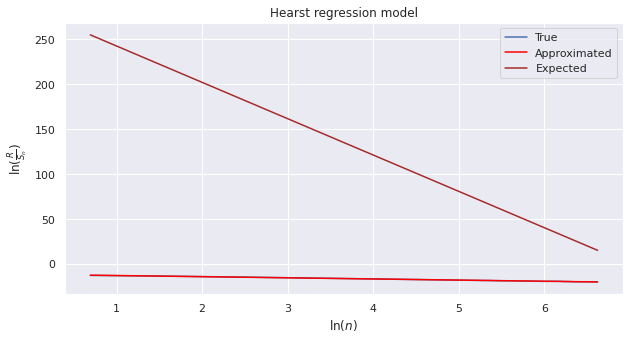

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=x, y=y)
sns.lineplot(x=x, y=solution.dot(np.vstack((x, np.ones(len(x))))), color='red')
sns.lineplot(x=x, y=solution_ideal.dot(np.vstack((x, np.ones(len(x))))), color='brown')
ax.set_xlabel(r'$\ln(n)$')
ax.set_ylabel(r'$\ln(\frac{R}{S_n})$')
ax.set_title('Hearst regression model')
ax.legend(['True', 'Approximated', 'Expected'])
plt.show()

In [ ]:
#compare to value, proposed by Anis and Lloyd by performing z-test
z = np.abs(solution_ideal[0]-solution[0])/(1/len(y))
p_val = norm.sf(np.abs(z))*2 #two-sided hypothesis check
print(f'Z = {z}\np = {p_val}')

Z = 29408.519917105292
p = 0.0


### Again, we can reject hypothesis of normal distribution of given system